In [1]:
import os, glob, sys
import time
import pandas as pd
import scipy as sp
import numpy as np
import statsmodels.api as sm

import nibabel as nib
from nilearn import plotting, masking, image, datasets

from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nistats.reporting import plot_design_matrix

%matplotlib inline 

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  # This is added back by InteractiveShellApp.init_path()
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models 

In [2]:
MODEL_NAME = 'pmod_pop_rank'
GROUP_DIR = '/data00/projects/megameta/group_models/'
output_dir = os.path.join(GROUP_DIR, 'custom', 'model_2nd-level_lm-{}'.format(MODEL_NAME))
os.makedirs(output_dir, exist_ok=True)

In [5]:
root_dir = '/data00/projects/megameta'

datasource = {
'Movietrailers': 'rsm_movietrailer/derivatives/nipype/model_MOVIE_pmod_pop_rank',
'TVC': 'rsm_tvc35/derivatives/nipype/model_TVC_pmod_pop_rank',
'DARPA': 'darpa1/derivatives/nipype/model_SHARE_pmod_pop_rank',
'CityYear': 'cityyear/derivatives/nipype/model_MESSAGE_pmod_pop_rank',
'Alcohol': 'alcohol/derivatives/nipype/model_TASK_pmod_pop_rank',
'Stanford': 'stanford_041320/derivatives/nipype/model_WATCH_pmod_pop_rank',
'Stanford_rate': 'stanford_041320/derivatives/nipype/model_RATE_pmod_pop_rank',
'Project1': 'project1/derivatives/nipype/model_BANNER_IMAGE_pmod_pop_rank' }

In [3]:
contrast_df = pd.read_csv('contrast_list.csv')

In [11]:
study = 'Stanford_rate'
study_path = 'stanford_041320/derivatives/nipype/model_RATE_pmod_pop_rank'

print(f"Scanning {study}...", end = " ")
con_files = glob.glob(os.path.join(root_dir, study_path, '*/*/*/con*.nii'))
print(f"{len(con_files)} contrasts found.")

for cf in con_files:
    description = nib.load(cf).header['descrip'].tolist().decode('utf-8')
    cf_parts = cf.split('/')

    entry = {
        'study': study,
        'subj': cf_parts[-4],
        'resolution': cf_parts[-3],
        'fwhm': cf_parts[-2],
        'path': cf,
        'contrast': description.split(": ")[-1],           
    }
    contrast_df = contrast_df.append(entry, ignore_index=True)
    print("*",end="")
print("")

Scanning Stanford_rate... 156 contrasts found.
************************************************************************************************************************************************************


In [5]:
if os.path.exists('contrast_list.csv'):
    contrast_df = pd.read_csv('contrast_list.csv')
else:
    contrast_list = []

    for study, study_path in datasource.items():
        print(f"Scanning {study}...", end = " ")
        con_files = glob.glob(os.path.join(root_dir, study_path, '*/*/*/con*.nii'))
        print(f"{len(con_files)} contrasts found.")

        for cf in con_files:
            description = nib.load(cf).header['descrip'].tolist().decode('utf-8')
            cf_parts = cf.split('/')

            entry = {
                'study': study,
                'subj': cf_parts[-4],
                'resolution': cf_parts[-3],
                'fwhm': cf_parts[-2],
                'path': cf,
                'contrast': description.split(": ")[-1],           
            }
            contrast_list.append(entry)
            print("*",end="")
        print("")
    
    contrast_df = pd.DataFrame(contrast_list)
    contrast_df.to_csv('contrast_list.csv',index=False)

In [12]:
contrast_df.groupby(['contrast','study']).describe().loc[:,('subj','count')]

contrast                                study        
constant                                Alcohol          56
                                        CityYear         39
                                        DARPA            41
                                        Movietrailers    25
                                        Project1         48
                                        Stanford         40
                                        Stanford_rate    39
                                        TVC              59
impure_message                          Alcohol          56
                                        DARPA            41
impure_messagexint_pop_rank^1           Alcohol          56
impure_messagexpmod_pop_retrans_rank^1  DARPA            41
non_message_event                       Alcohol          56
                                        CityYear         39
                                        DARPA            41
                                        Moviet

In [15]:
included_contrasts = ['pure_messagexint_pop_rank^1',
                      'pure_messagexpmod_pop_ctrmean_rank^1',
                      'pure_messagexpmod_pop_rank^1',
                      'pure_messagexpmod_pop_retrans_rank^1',
                      'pure_messagexpopulation_CTR_rank^1' ]

In [16]:
included_df = contrast_df[contrast_df.contrast.isin(included_contrasts)]
print(f"Duplicates: {included_df.duplicated(subset=['study','subj']).sum()}")

Duplicates: 0


In [17]:
included_df.study.value_counts()

TVC              59
Alcohol          56
Project1         48
DARPA            41
Stanford         40
CityYear         39
Stanford_rate    39
Movietrailers    25
Name: study, dtype: int64

In [18]:
#mask = '/data00/tools/spm8/apriori/brainmask_th25.nii'
mask = image.math_img('np.sign(img)', img=datasets.fetch_atlas_aal().maps)

template = '/data00/projects/megameta/templates/reference_medium_wad.nii'

mask = image.resample_to_img(mask, template, interpolation='linear')

In [19]:
nsamples = len(included_df)

## Intercept only

Not controlling for study.

/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


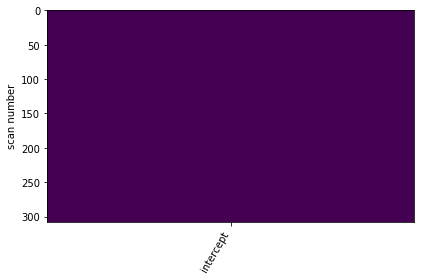

In [11]:
design_matrix = pd.DataFrame({'intercept': [1] * nsamples})
plot_design_matrix(design_matrix)

second_level_model = SecondLevelModel().fit(
    included_df.path.values.tolist(), design_matrix=design_matrix)

z_map = second_level_model.compute_contrast('intercept', output_type='z_score')

p < .001 uncorrected threshold: 3.291
p < .05 FDR threshold: inf


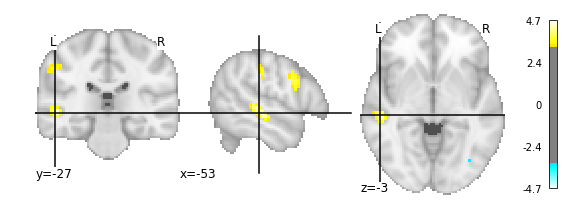

In [15]:
thresholded_map, threshold = map_threshold(
    z_map, mask_img=mask, alpha=.001, height_control='fpr', cluster_threshold=10)

print(f"p < .001 uncorrected threshold: {threshold:.3f}")
plotting.plot_stat_map(z_map, threshold=threshold)

thresholded_map, threshold = map_threshold(
    z_map, alpha=.05, height_control='fdr')

print(f"p < .05 FDR threshold: {threshold:.3f}")
z_map.to_filename(os.path.join(output_dir, f'{MODEL_NAME}_intercept_only.nii.gz'))


## Study fixed effects

Controlling for study but still looking at grand mean

/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


p < .001 uncorrected threshold: 3.291
p < .05 FDR threshold: inf


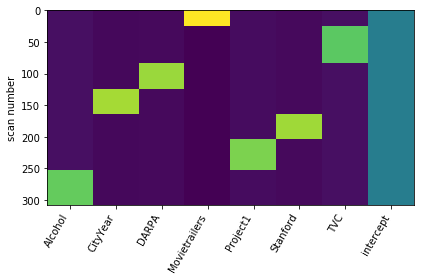

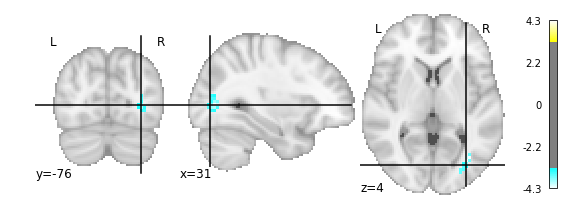

In [12]:
design_matrix = pd.get_dummies(included_df.study)
design_matrix -= np.mean(design_matrix.values)
design_matrix['intercept'] = 1
plot_design_matrix(design_matrix)

second_level_model = SecondLevelModel().fit(
    included_df.path.values.tolist(), design_matrix=design_matrix)

z_map = second_level_model.compute_contrast('intercept', output_type='z_score')

thresholded_map, threshold = map_threshold(
    z_map, mask_img=mask, alpha=.001, height_control='fpr', cluster_threshold=10)

print(f"p < .001 uncorrected threshold: {threshold:.3f}")
plotting.plot_stat_map(z_map, threshold=threshold)

thresholded_map, threshold = map_threshold(
    z_map, alpha=.05, height_control='fdr')

print(f"p < .05 FDR threshold: {threshold:.3f}")

z_map.to_filename(os.path.join(output_dir, f'{MODEL_NAME}_study_fixed_effects.nii.gz'))

In [ ]:
plotting.view_img(z_map, threshold=3.29)

## Marketing vs Health

In [18]:
marketing_studies = ['TVC', 'Stanford', 'Movietrailers']
health_studies = ['Alcohol', 'Project1', 'DARPA']

#leaving out cityyear here

Health (as intercept)

p < .001 uncorrected threshold: 3.291
p < .05 FDR threshold: 4.498


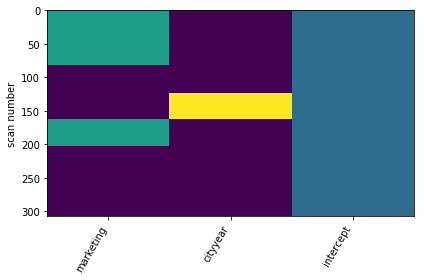

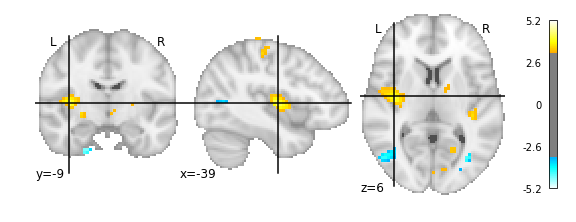

In [16]:
design_matrix = pd.DataFrame()
design_matrix['marketing'] = included_df.study.isin(marketing_studies).astype(int)
design_matrix['cityyear'] = (included_df.study == 'CityYear').astype(int)
design_matrix['intercept'] = 1
plot_design_matrix(design_matrix)

second_level_model = SecondLevelModel().fit(
    included_df.path.values.tolist(), design_matrix=design_matrix)

z_map = second_level_model.compute_contrast('intercept', output_type='z_score')

thresholded_map, threshold = map_threshold(
    z_map, mask_img=mask, alpha=.001, height_control='fpr', cluster_threshold=10)

print(f"p < .001 uncorrected threshold: {threshold:.3f}")
plotting.plot_stat_map(z_map, threshold=threshold)

thresholded_map, threshold = map_threshold(
    z_map, alpha=.05, height_control='fdr')

print(f"p < .05 FDR threshold: {threshold:.3f}")

z_map.to_filename(os.path.join(output_dir, f'{MODEL_NAME}_health_intercept.nii.gz'))

Marketing (as intercept)

p < .001 uncorrected threshold: 3.291
p < .05 FDR threshold: 3.911


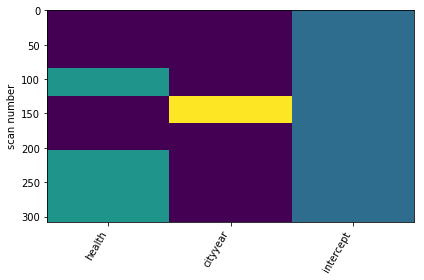

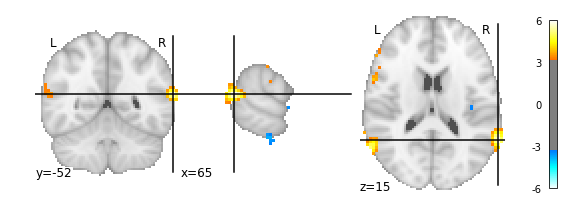

In [19]:
design_matrix = pd.DataFrame()
design_matrix['health'] = included_df.study.isin(health_studies).astype(int)
design_matrix['cityyear'] = (included_df.study == 'CityYear').astype(int)
design_matrix['intercept'] = 1
plot_design_matrix(design_matrix)

second_level_model = SecondLevelModel().fit(
    included_df.path.values.tolist(), design_matrix=design_matrix)

z_map = second_level_model.compute_contrast('intercept', output_type='z_score')

thresholded_map, threshold = map_threshold(
    z_map, mask_img=mask, alpha=.001, height_control='fpr', cluster_threshold=10)

print(f"p < .001 uncorrected threshold: {threshold:.3f}")
plotting.plot_stat_map(z_map, threshold=threshold)

thresholded_map, threshold = map_threshold(
    z_map, alpha=.05, height_control='fdr')

print(f"p < .05 FDR threshold: {threshold:.3f}")

z_map.to_filename(os.path.join(output_dir, f'{MODEL_NAME}_marketing_intercept.nii.gz'))

Difference map (Health > Marketing)

p < .001 uncorrected threshold: 3.291
p < .05 FDR threshold: 3.598


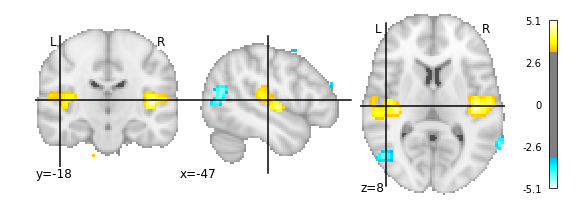

In [20]:
z_map = second_level_model.compute_contrast('health', output_type='z_score')

thresholded_map, threshold = map_threshold(
    z_map, mask_img=mask, alpha=.001, height_control='fpr', cluster_threshold=10)

print(f"p < .001 uncorrected threshold: {threshold:.3f}")
plotting.plot_stat_map(z_map, threshold=threshold)

thresholded_map, threshold = map_threshold(
    z_map, alpha=.05, height_control='fdr')

print(f"p < .05 FDR threshold: {threshold:.3f}")

## Marketing vs Health with study fixed effects (?????)

In [1]:
marketing_studies = ['TVC', 'Stanford', 'Movietrailers']

In [2]:
design_matrix = pd.get_dummies(included_df.study)
design_matrix -= np.mean(design_matrix.values)

design_matrix['marketing'] = included_df.study.isin(marketing_studies).astype(int)
design_matrix['intercept'] = 1
plot_design_matrix(design_matrix)

second_level_model = SecondLevelModel().fit(
    included_df.path.values.tolist(), design_matrix=design_matrix)

z_map = second_level_model.compute_contrast('intercept', output_type='z_score')

thresholded_map, threshold = map_threshold(
    z_map, mask_img=mask, alpha=.001, height_control='fpr', cluster_threshold=10)

print(f"p < .001 uncorrected threshold: {threshold:.3f}")
plotting.plot_stat_map(z_map, threshold=threshold)

thresholded_map, threshold = map_threshold(
    z_map, alpha=.05, height_control='fdr')

print(f"p < .05 FDR threshold: {threshold:.3f}")

z_map.to_filename(os.path.join(output_dir, f'{MODEL_NAME}_study_fixed_effects_health_intercept.nii.gz'))

NameError: name 'pd' is not defined

p < .001 uncorrected threshold: 3.291
p < .05 FDR threshold: inf


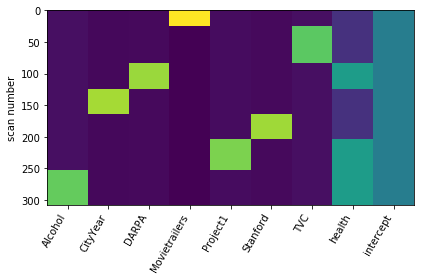

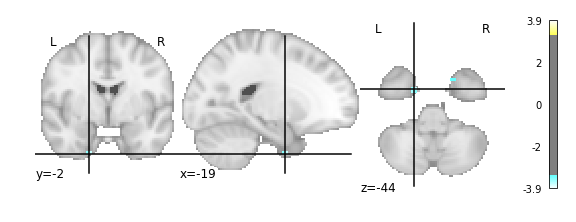

In [150]:
design_matrix = pd.get_dummies(included_df.study)
design_matrix -= np.mean(design_matrix.values)

design_matrix['health'] = 1 - included_df.study.isin(marketing_studies).astype(int)
design_matrix['intercept'] = 1
plot_design_matrix(design_matrix)

second_level_model = SecondLevelModel().fit(
    included_df.path.values.tolist(), design_matrix=design_matrix)

z_map = second_level_model.compute_contrast('intercept', output_type='z_score')

thresholded_map, threshold = map_threshold(
    z_map, mask_img=mask, alpha=.001, height_control='fpr', cluster_threshold=10)

print(f"p < .001 uncorrected threshold: {threshold:.3f}")
plotting.plot_stat_map(z_map, threshold=threshold)

thresholded_map, threshold = map_threshold(
    z_map, alpha=.05, height_control='fdr')

print(f"p < .05 FDR threshold: {threshold:.3f}")

z_map.to_filename(os.path.join(output_dir, f'{MODEL_NAME}_study_fixed_effects_marketing_intercept.nii.gz'))

## Second-level z-maps by study

/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


p < .001 uncorrected threshold: 3.291
p < .001 uncorrected threshold: 3.291
p < .001 uncorrected threshold: 3.291
p < .001 uncorrected threshold: 3.291
p < .001 uncorrected threshold: 3.291
p < .001 uncorrected threshold: 3.291
p < .001 uncorrected threshold: 3.291
p < .001 uncorrected threshold: 3.291


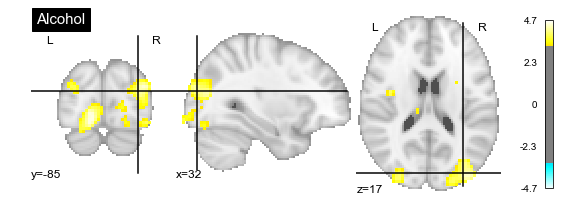

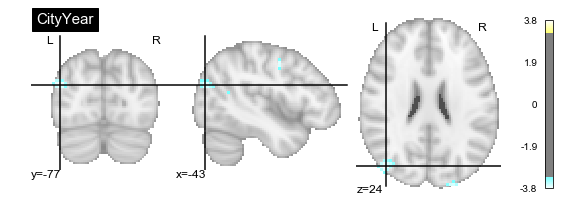

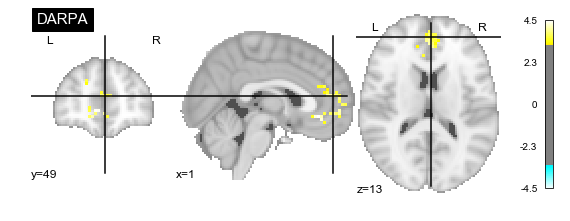

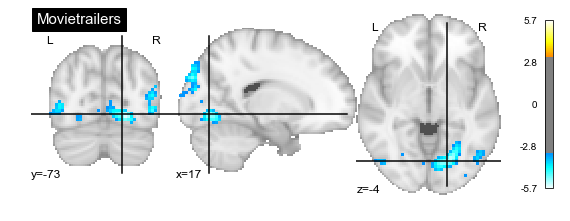

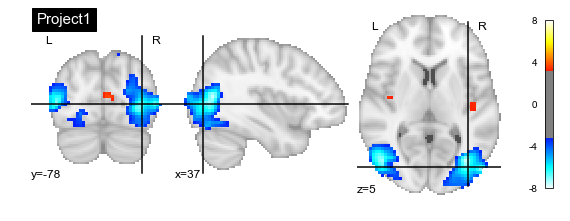

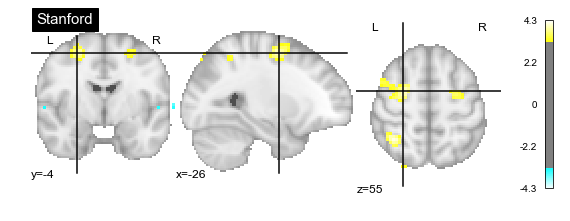

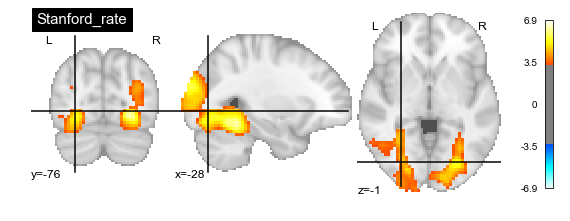

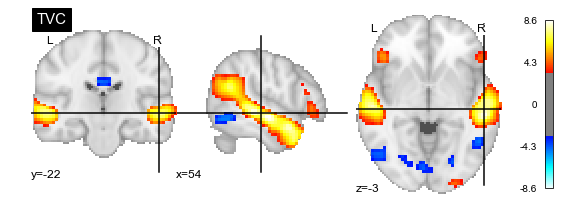

In [33]:
for study, study_df in included_df.groupby('study'):
    design_matrix = pd.DataFrame({'intercept': [1] * len(study_df)})

    second_level_model = SecondLevelModel().fit(
        study_df.path.values.tolist(), design_matrix=design_matrix)

    z_map = second_level_model.compute_contrast('intercept', output_type='z_score')

    thresholded_map, threshold = map_threshold(z_map, mask_img=mask, alpha=.001, height_control='fpr', cluster_threshold=10)

    print(f"p < .001 uncorrected threshold: {threshold:.3f}")
    plotting.plot_stat_map(z_map, threshold=threshold, title=study)

    z_map.to_filename(os.path.join(output_dir, f'{MODEL_NAME}_singlestudy_{study}.nii.gz'))


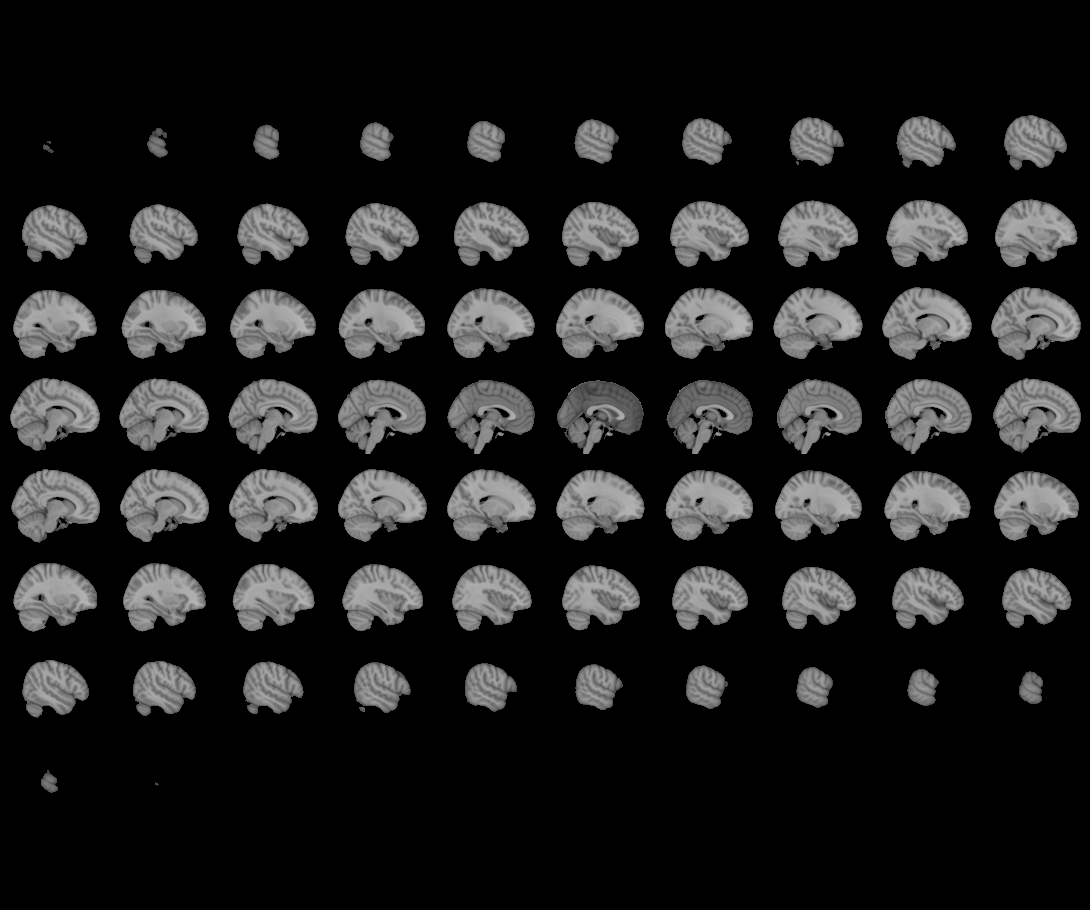
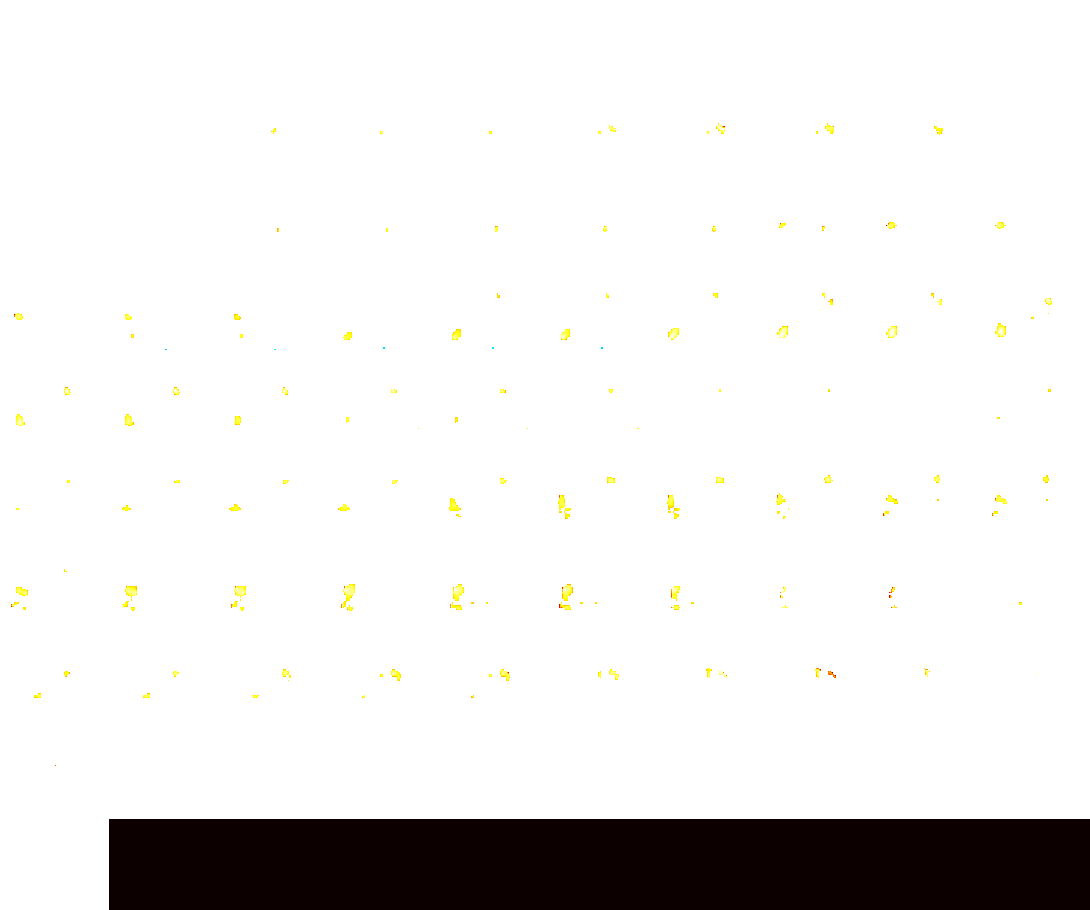

In [36]:
study = 'Alcohol'
z_map = os.path.join(output_dir, f'{MODEL_NAME}_singlestudy_{study}.nii.gz')
plotting.view_img(z_map, threshold=threshold)

In [22]:
studies = pd.unique(included_df.study)

for study in studies:
    z_map = image.math_img('np.abs(img)', img=os.path.join(output_dir, f'{MODEL_NAME}_singlestudy_{study}.nii.gz'))
    z_map.to_filename(os.path.join(output_dir, 'abs', f'{MODEL_NAME}_singlestudy_{study}.nii.gz'))

In [32]:
aal = datasets.fetch_atlas_aal()
mask = image.resample_to_img(image.math_img('np.sign(img)', img=aal.maps), included_df.path.values[0], interpolation='linear')

In [24]:
signals = masking.apply_mask([os.path.join(output_dir, f'{MODEL_NAME}_singlestudy_{study}.nii.gz') for study in studies], mask)

In [25]:
from scipy.spatial.distance import pdist, squareform

dist_matrix = squareform(pdist(signals, metric='correlation'))

In [26]:
import seaborn as sns
import matplotlib.pylab as plt
from scipy.cluster.hierarchy import dendrogram, linkage

In [27]:
import matplotlib.font_manager as font_manager

font_dirs = ['/data00/jupyterhub/hchan@asc.upenn.edu/fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
sns.set_style({"font.family":"Arial"})

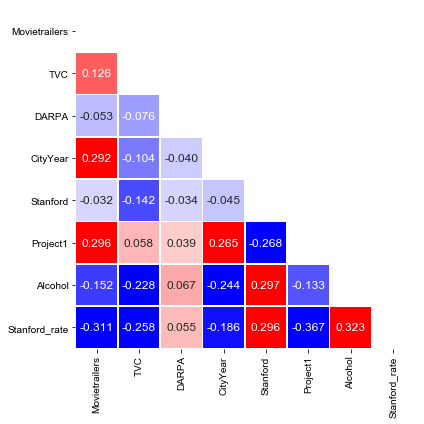

In [28]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6,6))
mask = np.zeros_like(dist_matrix, dtype=np.bool)
mask[np.triu_indices_from(dist_matrix)] = True

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(1-dist_matrix, mask=mask, vmin=-.2, vmax=.2, cmap='bwr',
            square=True, linewidths=.5, cbar=False, annot = True, fmt='.3f',
            annot_kws = {'size': 12}, xticklabels=studies, yticklabels=studies)
plt.tight_layout()

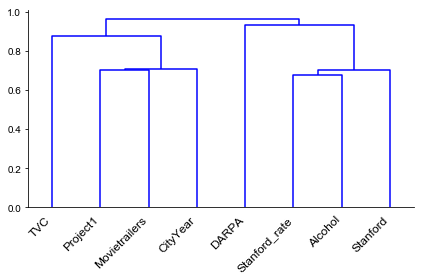

In [29]:
Z = linkage(squareform(dist_matrix), optimal_ordering=True)
dn = dendrogram(Z, labels=studies, leaf_rotation=45)
plt.xticks(ha='right')
sns.despine()
plt.tight_layout()